<p style="font-size:50px;color:gold">
<b>Intro to Data Science Project</b>
</p>

**_Juan Esteban Alarcón Bravo_**

<br/>

Analyzing organ donation data from Bogotá, Colombia, from 2015 to 2024.

<p style="font-size:30px;color:blue">
<b>Table of Contents</b>

1. [Imports and Cleanup](#1-imports-and-cleanup)
    - [Libraries](#11-libraries)
    - [Data](#12-data)
99. [Exhibits](#x-exhibits)

<br/>

# **1 - Imports and Cleanup**

To begin, we need to import and setup the necessary libraries, load the dataset, and perform some data cleaning.

## 1.1 - Libraries

In [23]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------

# Set pandas display options
pd.set_option('display.width', 1000)

# Set default colormap for Matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.colormaps['Set2'].colors)

## 1.2 - Data

First, we **import** the data from the CSV file into a pandas `DataFrame` and check the first rows, null values and the column names & data types.

In [3]:
# Load the dataset with encoding='latin1' for Spanish characters and using ";" as delimiter. Using dtype=object to avoid any automatic type conversion
data_path = 'data/raw_trasplantes.csv'
df = pd.read_csv(data_path, encoding='latin1', delimiter=';',dtype=object)

# Display the first few rows to check the data
df.head()

,Año,Proceso,Órgano,Sexo,Grupo de edad,Cantidad,Tipo de donante
0,2015,Donación,Riñón,Hombre,No aplica,39,Donante vivo
1,2015,Donación,Riñón,Mujer,No aplica,32,Donante vivo
2,2015,Donación,Riñón,Hombre,No aplica,70,Donante cadaverico
3,2015,Donación,Riñón,Mujer,No aplica,48,Donante cadaverico
4,2015,Donación,Corazón,Hombre,No aplica,0,Donante vivo


In [4]:
# Display the data types and check for missing values
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Año              2120 non-null   object
 1   Proceso          2120 non-null   object
 2   Órgano           2120 non-null   object
 3   Sexo             2120 non-null   object
 4   Grupo de edad    2120 non-null   object
 5   Cantidad         2120 non-null   object
 6   Tipo de donante  2120 non-null   object
dtypes: object(7)
memory usage: 116.1+ KB


Año                0
Proceso            0
Órgano             0
Sexo               0
Grupo de edad      0
Cantidad           0
Tipo de donante    0
dtype: int64

As there are no null values in the dataset, we do not need to worry about dealing with them. Also, all the columns but `Cantidad` _(Quantity)_ are categorical; our next step is going to be **text standardization** for those categorical columns.

- **Strip** spaces and put the text in **title case**.
- Check the **unique values** in each column to make sure that there are no duplicates or incorrect values (due to typos, etc.).

In [5]:
# Standardize text in categorical columns (Strip + TitleCase)
df['Año'] = df['Año'].str.strip().str.title()
df['Proceso'] = df['Proceso'].str.strip().str.title()
df['Órgano'] = df['Órgano'].str.strip().str.title()
df['Sexo'] = df['Sexo'].str.strip().str.title()
df['Grupo de edad'] = df['Grupo de edad'].str.strip().str.title()
df['Tipo de donante'] = df['Tipo de donante'].str.strip().str.title()

# Display the first few rows to check the data
df.head()

,Año,Proceso,Órgano,Sexo,Grupo de edad,Cantidad,Tipo de donante
0,2015,Donación,Riñón,Hombre,No Aplica,39,Donante Vivo
1,2015,Donación,Riñón,Mujer,No Aplica,32,Donante Vivo
2,2015,Donación,Riñón,Hombre,No Aplica,70,Donante Cadaverico
3,2015,Donación,Riñón,Mujer,No Aplica,48,Donante Cadaverico
4,2015,Donación,Corazón,Hombre,No Aplica,0,Donante Vivo


In [6]:
# Check for unique values in each column
print("Unique values in 'Año':", df['Año'].unique(), "\n")
print("Unique values in 'Proceso':", df['Proceso'].unique(), "\n")
print("Unique values in 'Órgano':", df['Órgano'].unique(), "\n")
print("Unique values in 'Sexo':", df['Sexo'].unique(), "\n")
print("Unique values in 'Grupo de edad':", df['Grupo de edad'].unique(), "\n")
print("Unique values in 'Tipo de donante':", df['Tipo de donante'].unique(), "\n")

Unique values in 'Año': ['2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023'
 '2024 Ii Trim'] 

Unique values in 'Proceso': ['Donación' 'Lista De Espera De Donación De Órganos' 'Trasplantes'
 'Donación Personas'] 

Unique values in 'Órgano': ['Riñón' 'Corazón' 'Hígado' 'Pulmón' 'Combinado Riñón-Hígado'
 'Tejidos (Córneas)' 'No Aplica' 'Combinado Corazón -Riñón' 'Páncreas'
 'Combinado \nRiñón-Páncreas' 'Combinado Riñón-Pancreas'] 

Unique values in 'Sexo': ['Hombre' 'Mujer' 'No Aplica'] 

Unique values in 'Grupo de edad': ['No Aplica' '0-9 Años' '10-19 Años' '20-29 Años' '30-39 Años'
 '40-49 Años' '50-59 Años' '60-69 Años' '> 70  Años'] 

Unique values in 'Tipo de donante': ['Donante Vivo' 'Donante Cadaverico' 'No Aplica' 'Donante Cadavérico'] 



Some values require attention. In `Año` (_"Year"_), for instance, the year _2024_ includes not only the year itself but also an indication of the trimester (_"2024 Ii Trim"_). This shows a clear bias in the data, as the year 2024 contains fewer observations compared to other years, which represent complete annual data.

<div class="alert alert-block alert-info">
<b>Note:</b> This particular year-bias is going to be important for some of the next steps of the project but, for the time being, we are going to change all the occurrences to "2024".
</div>

As for the other columns, there are some missing and extra characters and accents. We can work on that: 

In [7]:
# Cleanup: 'Año' (Year)
df['Año'] = df['Año'].replace({
    '2024 Ii Trim': '2024'
})

# Cleanup: 'Proceso' (Process)
df['Proceso'] = df['Proceso'].replace({
    'Lista De Espera De Donación De Órganos': 'Lista de Espera',
    'Trasplantes': 'Trasplante',
})

# Cleanup: 'Órgano' (Organ)
df['Órgano'] = df['Órgano'].replace({
    'Combinado Corazón -Riñón': 'Combinado Corazón-Riñón',
    'Combinado \nRiñón-Páncreas': 'Combinado Riñón-Páncreas',
    'Combinado Riñón-Pancreas': 'Combinado Riñón-Páncreas',
    'Tejidos (Córneas)': 'Córneas'
})

# Cleanup: 'Grupo de edad' (Age Group)
df['Grupo de edad'] = df['Grupo de edad'].replace({
    '> 70  Años': '> 70 Años'
})

# Cleanup: 'Tipo de donante' (Donor Type)
df['Tipo de donante'] = df['Tipo de donante'].replace({
    'Donante Vivo': 'Vivo',
    'Donante Cadaverico': 'Cadavérico',
    'Donante Cadavérico': 'Cadavérico',
})

In [8]:
# Check unique values in each modified column
print("Unique values in 'Año':", df['Año'].unique(), "\n")
print("Unique values in 'Proceso':", df['Proceso'].unique(), "\n")
print("Unique values in 'Órgano':", df['Órgano'].unique(), "\n")
print("Unique values in 'Grupo de edad':", df['Grupo de edad'].unique(), "\n")
print("Unique values in 'Tipo de donante':", df['Tipo de donante'].unique(), "\n")

Unique values in 'Año': ['2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023' '2024'] 

Unique values in 'Proceso': ['Donación' 'Lista de Espera' 'Trasplante' 'Donación Personas'] 

Unique values in 'Órgano': ['Riñón' 'Corazón' 'Hígado' 'Pulmón' 'Combinado Riñón-Hígado' 'Córneas'
 'No Aplica' 'Combinado Corazón-Riñón' 'Páncreas'
 'Combinado Riñón-Páncreas'] 

Unique values in 'Grupo de edad': ['No Aplica' '0-9 Años' '10-19 Años' '20-29 Años' '30-39 Años'
 '40-49 Años' '50-59 Años' '60-69 Años' '> 70 Años'] 

Unique values in 'Tipo de donante': ['Vivo' 'Cadavérico' 'No Aplica'] 



We should also change the data type of `Año` and `Cantidad` to numeric.

In [9]:
#  Change 'Año' to numeric
df['Año'] = pd.to_numeric(df['Año'], errors='coerce')

#  Change 'Cantidad' to numeric
df['Cantidad'] = pd.to_numeric(df['Cantidad'], errors='coerce')

# Check for null values
df.isnull().sum()

Año                0
Proceso            0
Órgano             0
Sexo               0
Grupo de edad      0
Cantidad           0
Tipo de donante    0
dtype: int64

<br/>

# **2 - Data Analysis**

## 2.1 - How have the total transplants evolved from 2015 to 2024?

We will work with a subset of the main dataframe (`df`) with only the transplant rows: `df_tr`.

In [19]:
# Filter rows where the "Proceso" column is equal to "Trasplante"
df_tr = df[df['Proceso'] == 'Trasplante']

The `Cantidad` column represent a wide range of numerical values, so we start by doing some **descriptive statistics** to get a better understanding of the data.

In [29]:
# Statistical description of the Cantidad column
print("Descriptive statistics for Cantidad:")
print(df_tr['Cantidad_log'].describe())

# Print the Median
print(f"\nMedian: {df_tr['Cantidad'].median()}")

# Calculate the IQR and the limits
q1 = df_tr['Cantidad'].quantile(0.25)
q3 = df_tr['Cantidad'].quantile(0.75)
iqr = q3 - q1

lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

print(f"IQR:{iqr}\nLower limit: {lower_limit}\nUpper limit: {upper_limit}")

Descriptive statistics for Cantidad:
count    944.000000
mean       1.318830
std        1.431216
min        0.000000
25%        0.000000
50%        0.693147
75%        2.302585
max        5.318120
Name: Cantidad_log, dtype: float64

Median: 1.0
IQR:9.0
Lower limit: -13.5
Upper limit: 22.5


Some observations:
- The `mean` (_~11_) is significantly lower than the `max` (_203_). This hints that the distribution is **right skewed**.
- Also, the `median` (_1_) is smaller than the `mean` (_11_), further supporting this hypothesis.

With that in mind, we now check the IQR and limits, and their relationship with the actual data:
- First, while the `lower limit` is _-13.5_, the `min` is _0_. Thus, there are **no negative outliers** in the data.
- On the other hand, the `upper limit` is _22.5_, so every value above that should be considered an outlier.

Visualizing the data, we can notice the big tail of the distribution (skewness) in the histogram, and the outliers in the boxplot:

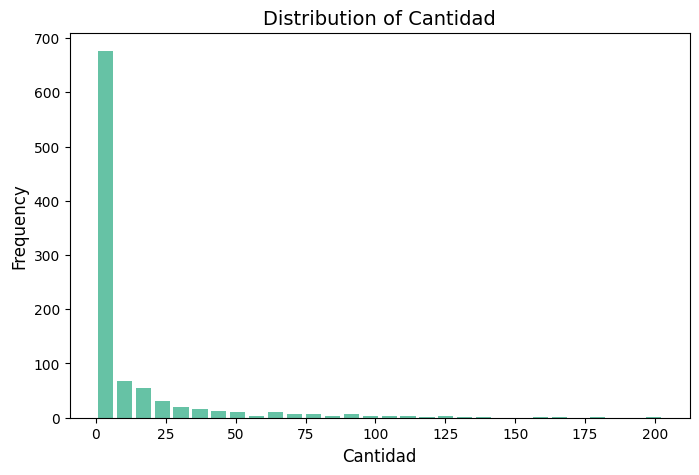

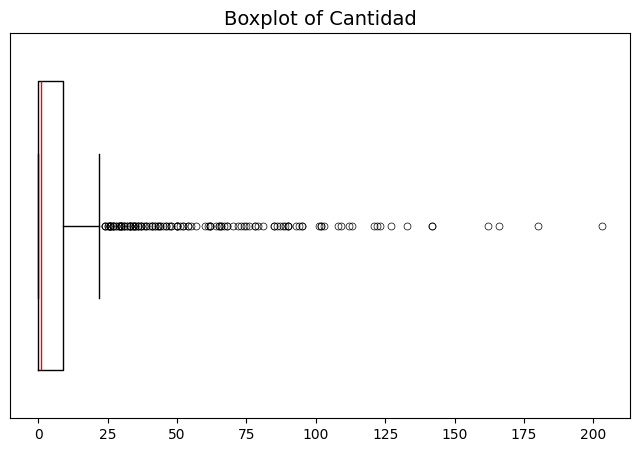

In [ ]:
# Histogram: Cantidad
plt.figure(figsize=(8, 5))
plt.hist(df_tr['Cantidad'], bins=30, rwidth=0.8)
plt.title('Distribution of Cantidad', fontsize=14)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Boxplot: Cantidad
plt.figure(figsize=(8, 5))
medianprops = dict(linestyle='-', color='red')
flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markeredgewidth=0.5)
plt.boxplot(df_tr['Cantidad'], vert=False, medianprops=medianprops, flierprops=flierprops, widths=(0.75))
plt.title('Boxplot of Cantidad', fontsize=14)
plt.yticks([])  # Remove y-axis labels
plt.show()

To address this skewness, we will aply a <span style="color:teal">**log transformation**</span> to the data and then generate the statistical summary and plots again.

<div class="alert alert-block alert-success">
  <span>✅</span> One of the most important advantages of this technique compared to other alternatives (such as <em>min-max</em> or <em>z-score</em>) is the <strong>reduction of the asymmetry</strong> of the distribution, a very valuable point when dealing with extreme outliers that we are not removing.
</div>

Descriptive statistics for Cantidad_log:
count    944.000000
mean       1.318830
std        1.431216
min        0.000000
25%        0.000000
50%        0.693147
75%        2.302585
max        5.318120
Name: Cantidad_log, dtype: float64

Median: 0.6931471805599453
IQR: 2.302585092994046
Lower limit: -3.453877639491069
Upper limit: 5.756462732485115



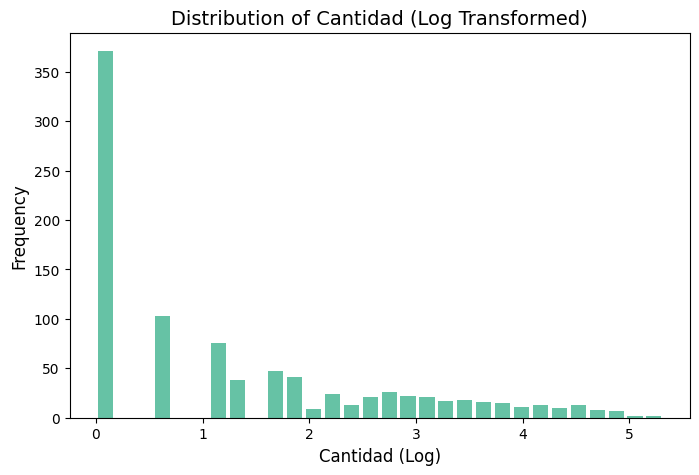

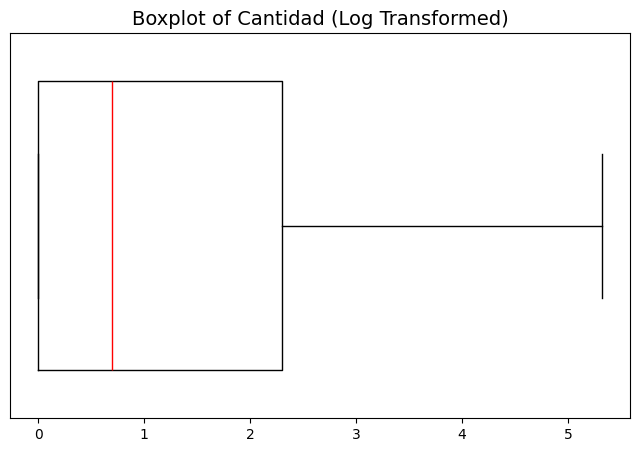

In [27]:
# Apply log transformation to 'Cantidad'
df_tr.loc[:, 'Cantidad_log'] = np.log1p(df_tr['Cantidad'])  # .loc to get rid of a Warning

# Descriptive statistics
print("Descriptive statistics for Cantidad_log:")
print(df_tr['Cantidad_log'].describe())

# The median
print(f"\nMedian: {df_tr['Cantidad_log'].median()}")

# Calculate the IQR and the limits for the log-transformed column
q1_log = df_tr['Cantidad_log'].quantile(0.25)
q3_log = df_tr['Cantidad_log'].quantile(0.75)
iqr_log = q3_log - q1_log

lower_limit_log = q1_log - 1.5 * iqr_log
upper_limit_log = q3_log + 1.5 * iqr_log

print(f"IQR: {iqr_log}\nLower limit: {lower_limit_log}\nUpper limit: {upper_limit_log}\n")


# Then, we plot again...

# Histogram: Cantidad (log-transformed)
plt.figure(figsize=(8, 5))
plt.hist(df_tr['Cantidad_log'], bins=30, rwidth=0.8)
plt.title('Distribution of Cantidad (Log Transformed)', fontsize=14)
plt.xlabel('Cantidad (Log)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Boxplot: Cantidad (log-transformed)
plt.figure(figsize=(8, 5))
medianprops = dict(linestyle='-', color='red')
flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markeredgewidth=0.5)
plt.boxplot(df_tr['Cantidad_log'], vert=False, medianprops=medianprops, flierprops=flierprops, widths=(0.75))
plt.title('Boxplot of Cantidad (Log Transformed)', fontsize=14)
plt.yticks([])  # Remove y-axis labels
plt.show()

<br/>

# **?. Descriptive Statistics**

With the categorical cleanup finished, we can work on the remaining column: `Cantidad`. As this column represent a wide range of numerical values, we start by doing some **descriptive statistics** to get a better understanding of the data.

In [11]:
# SDtatistical description of the Cantidad column
df['Cantidad'].describe()

count    2120.000000
mean       19.068396
std        41.635948
min         0.000000
25%         0.000000
50%         2.000000
75%        15.000000
max       283.000000
Name: Cantidad, dtype: float64

In [12]:
# Print the Median
print(f"Median: {df['Cantidad'].median()}")

# Calculate the IQR and the limits
q1 = df['Cantidad'].quantile(0.25)
q3 = df['Cantidad'].quantile(0.75)
iqr = q3 - q1

lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

print(f"IQR:{iqr}\nLower limit: {lower_limit}\nUpper limit: {upper_limit}")

Median: 2.0
IQR:15.0
Lower limit: -22.5
Upper limit: 37.5


Some observations:
- The `mean` (_~19_) is significantly lower than the `max` (_283_). This hints that the distribution is **right skewed**.
- Also, the `median` (_2_) is smaller than the `mean` (_19_), further supporting this hypothesis.

With that in mind, we now check the IQR and limits, and their relationship with the actual data:
- First, while the `lower limit` is _-22.5_, the `min` is _0_. Thus, there are **no negative outliers** in the data.
- On the other hand, the `upper limit` is _37.5_, so every value above that should be considered an outlier.

Visualizing the data, we can notice the big tail of the distribution (skewness) in the histogram, and the outliers in the boxplot:

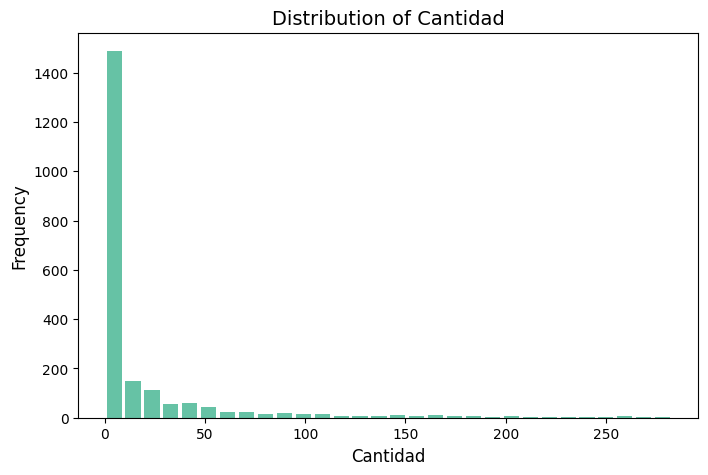

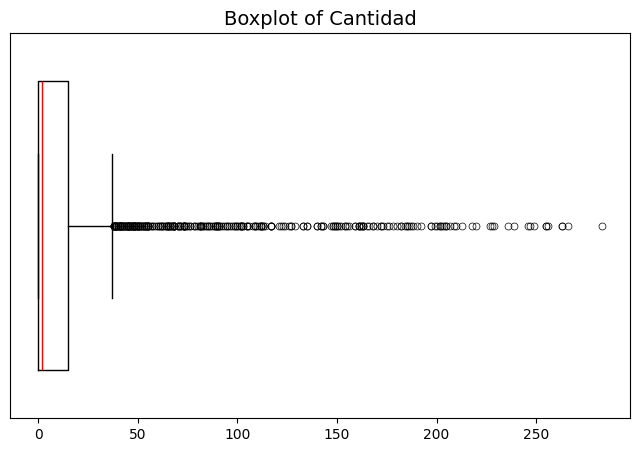

In [13]:
# Paint with custom colors
# colors = plt.colormaps['Set2'].colors
# plt.hist(df['Cantidad'], bins=30, color=colors[0], rwidth=0.8)

# Histogram: Cantidad
plt.figure(figsize=(8, 5))
plt.hist(df['Cantidad'], bins=30, rwidth=0.8)
plt.title('Distribution of Cantidad', fontsize=14)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Boxplot: Cantidad
plt.figure(figsize=(8, 5))
medianprops = dict(linestyle='-', color='red')
flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markeredgewidth=0.5)
plt.boxplot(df['Cantidad'], vert=False, medianprops=medianprops, flierprops=flierprops, widths=(0.75))
plt.title('Boxplot of Cantidad', fontsize=14)
plt.yticks([])  # Remove y-axis labels
plt.show()

In [14]:
# Inspeccionar los posibles outliers
# outliers = df[df['Cantidad'] > upper_limit]
# print(outliers)

# Trasplantes 2015
print("Trasplantes 2015")
outliers = df[(df['Proceso'] == "Trasplante") & (df['Año'] == 2015) & (df['Órgano'] == "Riñón") & (df['Sexo'] == "Hombre")]
print(outliers)

print("\n----------------------------\n")

# Donaciones 2015 (Total: 309)
print("Lista de Espera 2015")
outliers = df[(df['Proceso'] == "Lista de Espera") & (df['Año'] == 2015) & (df['Órgano'] == "Riñón") & (df['Sexo'] == "Hombre")]
print(outliers)

print("\n----------------------------\n")

# "Donación Personas" 2015 (81 Vivo, 152 Cadavérico)
print("Donación Personas 2015")
outliers = df[(df['Proceso'] == "Donación Personas") & (df['Año'] == 2015) & (df['Tipo de donante'] == "Vivo")]
print(outliers)

print("\n----------------------------\n")

# Contar cuántos registros hay para cada valor de 'Proceso'
proceso_counts = df['Proceso'].value_counts()
print(proceso_counts)

Trasplantes 2015
      Año     Proceso Órgano    Sexo Grupo de edad  Cantidad Tipo de donante
864  2015  Trasplante  Riñón  Hombre      0-9 Años         4       No Aplica
865  2015  Trasplante  Riñón  Hombre    10-19 Años        12       No Aplica
866  2015  Trasplante  Riñón  Hombre    20-29 Años        16       No Aplica
867  2015  Trasplante  Riñón  Hombre    30-39 Años        30       No Aplica
868  2015  Trasplante  Riñón  Hombre    40-49 Años        26       No Aplica
869  2015  Trasplante  Riñón  Hombre    50-59 Años        41       No Aplica
870  2015  Trasplante  Riñón  Hombre    60-69 Años        36       No Aplica
871  2015  Trasplante  Riñón  Hombre     > 70 Años         2       No Aplica

----------------------------

Lista de Espera 2015
      Año          Proceso Órgano    Sexo Grupo de edad  Cantidad Tipo de donante
160  2015  Lista de Espera  Riñón  Hombre      0-9 Años         3       No Aplica
161  2015  Lista de Espera  Riñón  Hombre    10-19 Años        17       No

<br/>
<br/>
<br/>
<br/>
<br/>

# **x. Exhibits**

Additional tools that come in handy for the project execution.

## x.1 - Python _requirements.txt_ utilities

In [15]:
# Create requirements.txt file
# !pip freeze > requirements.txt

# Install requirements.txt
# !pip install -r requirements.txt